# **Elaborar en spark usando ML 1 modelo de clasificación como Árboles de Decisión, Random Forest y Regresión Logística Multiclase. Y generar una tabla donde comparen accuracy, recall, f1-score y pérdida.**

In [ ]:
import org.apache.spark.sql.functions._

val mlDF = postulanteDF.
  join(postulacionDF, "UUID").
  join(carreraDF_clean, "ID_AREA").
  join(ubicacionDF_clean, "UBIGEO").
  select(
    col("SITUACION"),   // etiqueta
    col("SEXO"),
    col("EDAD"),
    col("NOTA"),
    col("ID_AREA"),
    col("DEPARTAMENTO")
  ).na.drop()


In [ ]:
import org.apache.spark.ml.feature.{StringIndexer, VectorAssembler}

val indexerSexo   = new StringIndexer().setInputCol("SEXO").setOutputCol("sexo_idx")
val indexerDepto  = new StringIndexer().setInputCol("DEPARTAMENTO").setOutputCol("depto_idx")
val indexerLabel  = new StringIndexer().setInputCol("SITUACION").setOutputCol("label")

val assembler = new VectorAssembler().
  setInputCols(Array("EDAD", "NOTA", "ID_AREA", "sexo_idx", "depto_idx")).
  setOutputCol("features")


El indexer convierte cada categoría distinta de SITUACION a un índice:

0.0 → una categoría ("NO ALCANZO VACANTE")

1.0 → otra ( "POSTULANTE LIBRE")

2.0 → otra ("ALCANZO VACANTE")

3.0 → otra, si existe

In [ ]:
val Array(train, test) = mlDF.randomSplit(Array(0.8, 0.2), seed = 1234)


In [ ]:
import org.apache.spark.ml.classification.DecisionTreeClassifier

val dt = new DecisionTreeClassifier().
  setFeaturesCol("features").
  setLabelCol("label")


In [ ]:
import org.apache.spark.ml.classification.RandomForestClassifier

val rf = new RandomForestClassifier().
  setFeaturesCol("features").
  setLabelCol("label").
  setNumTrees(100)


In [ ]:
import org.apache.spark.ml.classification.LogisticRegression

val lr = new LogisticRegression().
  setFeaturesCol("features").
  setLabelCol("label").
  setMaxIter(50).
  setFamily("multinomial")


In [ ]:
import org.apache.spark.ml.Pipeline

val pipelineDT = new Pipeline().setStages(Array(indexerSexo, indexerDepto, indexerLabel, assembler, dt))
val pipelineRF = new Pipeline().setStages(Array(indexerSexo, indexerDepto, indexerLabel, assembler, rf))
val pipelineLR = new Pipeline().setStages(Array(indexerSexo, indexerDepto, indexerLabel, assembler, lr))


In [ ]:
val dtModel = pipelineDT.fit(train)
val rfModel = pipelineRF.fit(train)
val lrModel = pipelineLR.fit(train)


In [ ]:
val dtPred = dtModel.transform(test)
val rfPred = rfModel.transform(test)
val lrPred = lrModel.transform(test)


In [ ]:
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator

val accEval = new MulticlassClassificationEvaluator().setMetricName("accuracy")

val f1Eval = new MulticlassClassificationEvaluator().setMetricName("f1")

val recallEval = new MulticlassClassificationEvaluator().setMetricName("weightedRecall")


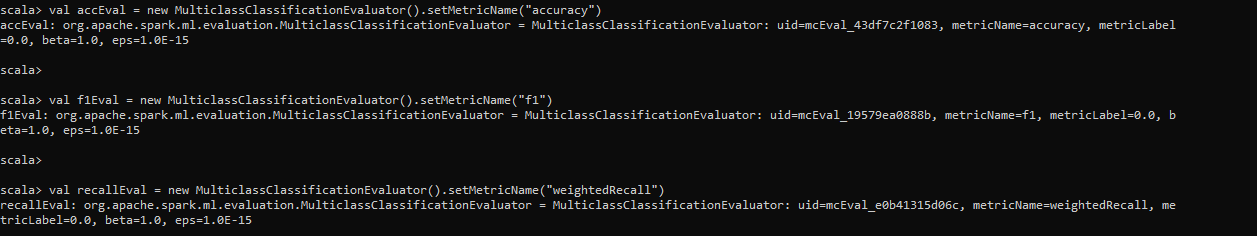

In [ ]:
val dtAcc    = accEval.evaluate(dtPred)
val dtF1     = f1Eval.evaluate(dtPred)
val dtRecall = recallEval.evaluate(dtPred)


val rfAcc    = accEval.evaluate(rfPred)
val rfF1     = f1Eval.evaluate(rfPred)
val rfRecall = recallEval.evaluate(rfPred)


val lrAcc    = accEval.evaluate(lrPred)
val lrF1     = f1Eval.evaluate(lrPred)
val lrRecall = recallEval.evaluate(lrPred)



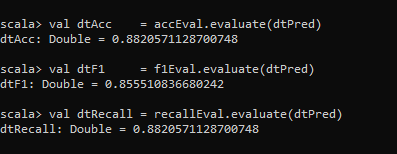

In [ ]:
import org.apache.spark.sql.functions._
import org.apache.spark.ml.linalg.Vector

def computeLogLoss(df: org.apache.spark.sql.DataFrame): Double = {
  val eps = 1e-15

  val loglossDF = df.select(
    col("label").cast("double"),
    col("probability")
  ).rdd.map { row =>
    val label = row.getDouble(0)
    val probVector = row.getAs[Vector]("probability")

    val p = probVector(label.toInt)

    -math.log(math.max(p, eps))
  }

  loglossDF.mean()
}


In [ ]:
val dtLoss = computeLogLoss(dtPred)
val rfLoss = computeLogLoss(rfPred)
val lrLoss = computeLogLoss(lrPred)


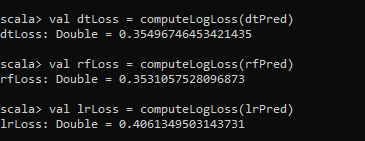

In [ ]:
val resultados = Seq(
  ("Decision Tree", dtAcc, dtRecall, dtF1, dtLoss),
  ("Random Forest", rfAcc, rfRecall, rfF1, rfLoss),
  ("Logistic Regression", lrAcc, lrRecall, lrF1, lrLoss)
).toDF("Modelo", "Accuracy", "Recall", "F1_score", "LogLoss")

resultados.show(false)


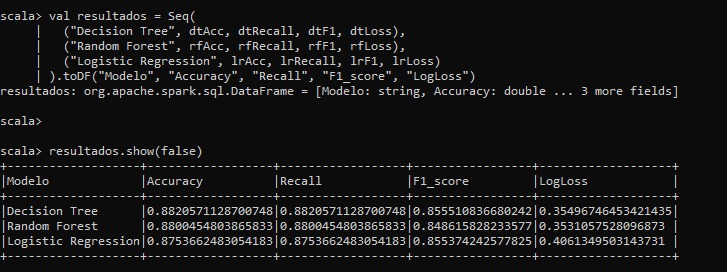

El modelo con mejor desempeño general es el Árbol de Decisión, ya que obtiene la mayor exactitud (88.20%), el mejor recall y el mejor F1-score conjunto. Por otro lado, el Random Forest presenta la menor pérdida logarítmica (LogLoss = 0.3531), lo que lo convierte en el modelo con mejores probabilidades calibradas. La Regresión Logística, aunque obtiene un F1-score competitivo, presenta el peor LogLoss, lo que indica que sus probabilidades no están bien ajustadas.

**Mostrar algunos ejemplos pruebas o predicciones a partir de los modelos**


1. Mostrar 10 predicciones del Árbol de Decisión

label_real
Es la clase original en texto, la columna SITUACION de tu dataset:
por ejemplo, "ALCANZO VACANTE" o "NO ALCANZO VACANTE".

label_predicha (0.0, 1.0, 2.0, …)
Es la clase codificada en número después del StringIndexer

probability = vector de probabilidades

In [ ]:
dtPred.select(
  $"SITUACION".alias("label_real"),
  $"prediction".alias("label_predicha"),
  $"probability"
).show(100, false)


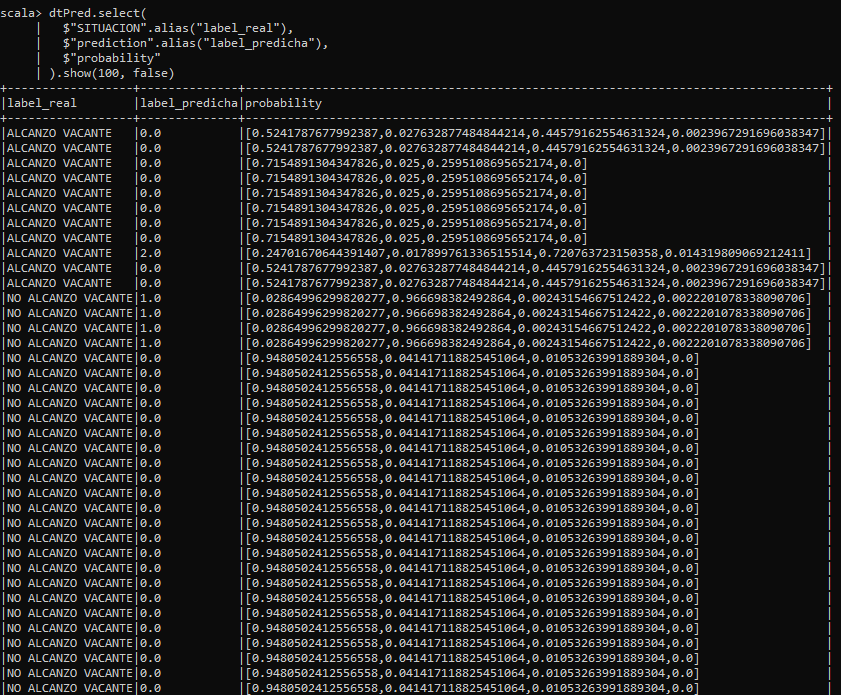

El modelo cree que:

Clase 0 ≈ 52.4%

Clase 2 ≈ 44.6%

Clases 1 y 3 casi nada

Como el valor mayor es el de la posición 0, la prediction = 0.0.

La real es ALCANZO VACANTE.

La predicha es clase 0.0, que por el contexto debe ser otra ( NO ALCANZO VACANTE).

En el primer caso:

El modelo está dudoso: 52% vs 44% entre clase 0 y clase 2.

Sin embargo, hay muchos otros casos donde si concidie 0.0 = NO ANCAZO VACANTE

2. Mostrar 10 predicciones del Random Forest

In [ ]:
rfPred.select(
  $"SITUACION".alias("label_real"),
  $"prediction".alias("label_predicha"),
  $"probability"
).show(100, false)


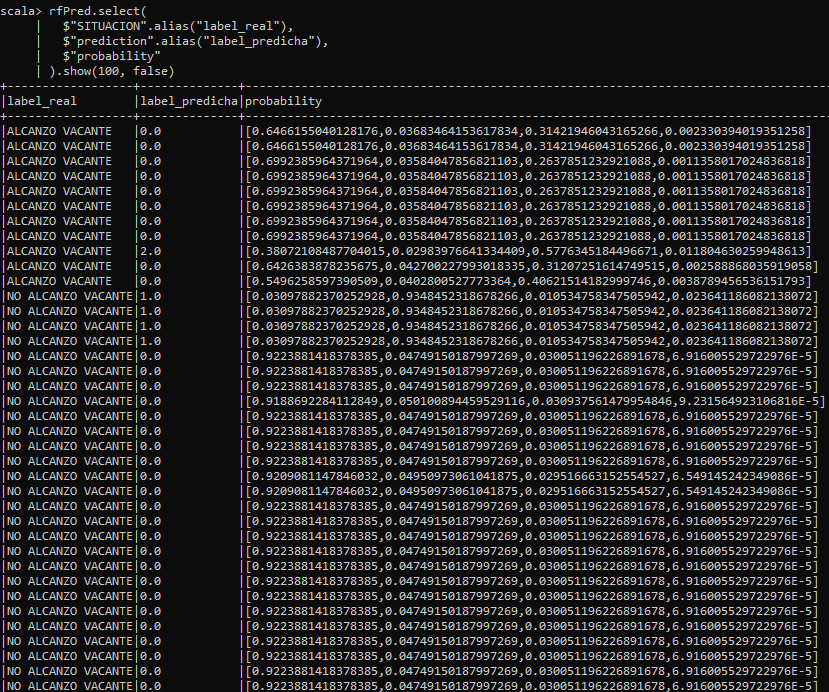

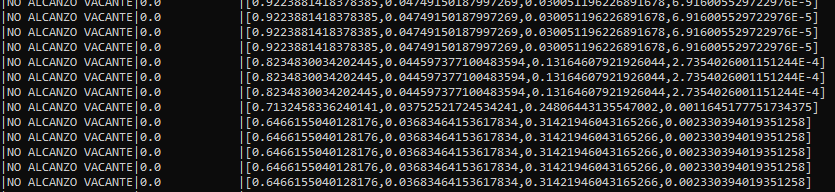

3. Mostrar 10 predicciones de la Regresión Logística

In [ ]:
lrPred.select(
  $"SITUACION".alias("label_real"),
  $"prediction".alias("label_predicha"),
  $"probability"
).show(100, false)


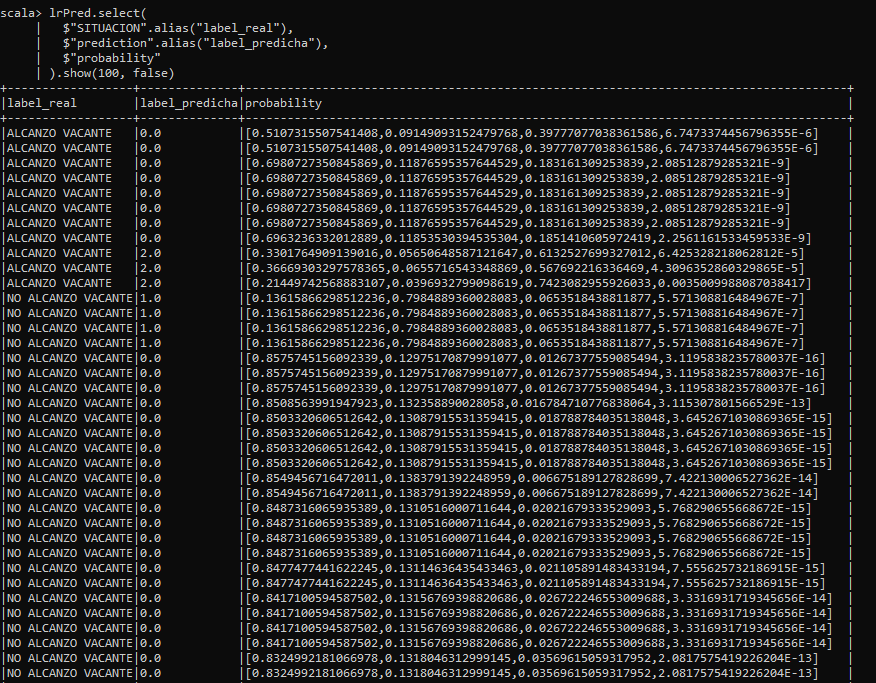

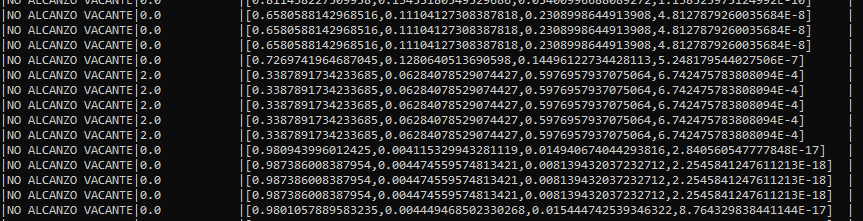

Ejemplo donde el modelo falló

In [ ]:
dtPred.filter($"label" =!= $"prediction").
  select("SITUACION", "prediction", "probability").
  show(10, false)


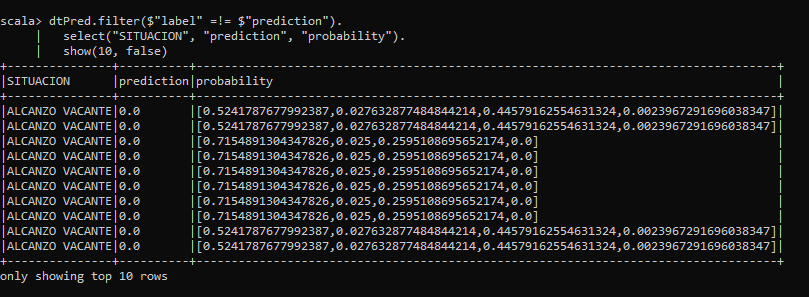

Ejemplo donde el modelo acertó

In [ ]:
dtPred.filter($"label" === $"prediction").
  select("SITUACION", "prediction", "probability").
  show(10, false)


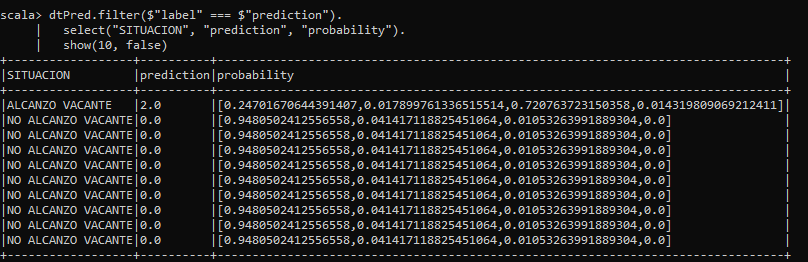

**Interpretación resultados**

Los tres modelos muestran un rendimiento sólido, pero cada uno presenta comportamientos distintos ante los mismos datos. El Árbol de Decisión da la mejor exactitud global, pero es el más rígido en cambiar de clase y requiere probabilidades muy dominantes para hacerlo. El Random Forest es el modelo más robusto y equilibrado; ofrece las probabilidades mejor calibradas (menor LogLoss) y reconoce patrones complejos, por lo que es el más confiable si se desea utilizar las probabilidades como criterio de decisión. La Regresión Logística, pese a tener un F1 competitivo, presenta la peor calibración de probabilidades, mostrando confianza excesiva en ciertas clases.

# **Elaborar en spark usando ML 1 modelo de regresión Regresión lineal y Multilayer Perceptron Y generar una tabla donde comparen accuracy, recall, f1-score y pérdida.**

In [ ]:
import org.apache.spark.sql.functions._
import org.apache.spark.ml.feature.{StringIndexer, VectorAssembler}
import org.apache.spark.ml.classification.MultilayerPerceptronClassifier
import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.evaluation.{MulticlassClassificationEvaluator, RegressionEvaluator}

// ==============================
//  PREPARAR FEATURES
// ==============================

// Indexadores (ya hechos antes)
val indexerSexo   = new StringIndexer().setInputCol("SEXO").setOutputCol("sexo_idx")
val indexerDepto  = new StringIndexer().setInputCol("DEPARTAMENTO").setOutputCol("depto_idx")
val indexerLabel  = new StringIndexer().setInputCol("SITUACION").setOutputCol("label")

// Assembler para REGRESIÓN
val assemblerReg = new VectorAssembler().
  setInputCols(Array("EDAD", "ID_AREA", "sexo_idx", "depto_idx")).
  setOutputCol("features")

// Assembler para MLP clasificación
val assemblerMLP = new VectorAssembler().
  setInputCols(Array("EDAD", "NOTA", "ID_AREA", "sexo_idx", "depto_idx")).
  setOutputCol("features")

val Array(train, test) = mlDF.randomSplit(Array(0.8, 0.2), seed = 1234)


In [ ]:
val lrReg = new LinearRegression().
  setLabelCol("NOTA").
  setFeaturesCol("features")

val pipelineReg = new Pipeline().setStages(Array(indexerSexo, indexerDepto, assemblerReg, lrReg))

val modelReg = pipelineReg.fit(train)
val predReg = modelReg.transform(test)

// Métricas de regresión
val evaluatorRMSE = new RegressionEvaluator().setLabelCol("NOTA").setMetricName("rmse")
val evaluatorMAE  = new RegressionEvaluator().setLabelCol("NOTA").setMetricName("mae")
val evaluatorR2   = new RegressionEvaluator().setLabelCol("NOTA").setMetricName("r2")

val rmse = evaluatorRMSE.evaluate(predReg)
val mae  = evaluatorMAE.evaluate(predReg)
val r2   = evaluatorR2.evaluate(predReg)


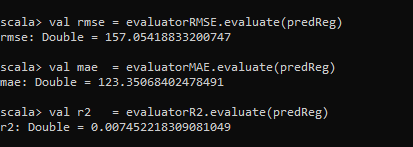

In [ ]:
val numClases = mlDF.select("SITUACION").distinct().count().toInt

val layers = Array[Int](5, 8, 6, numClases)

val mlp = new MultilayerPerceptronClassifier().
  setLabelCol("label").
  setFeaturesCol("features").
  setLayers(layers).
  setMaxIter(200)

val pipelineMLP = new Pipeline().setStages(Array(indexerSexo, indexerDepto, indexerLabel, assemblerMLP, mlp))

val modelMLP = pipelineMLP.fit(train)
val predMLP = modelMLP.transform(test)


In [ ]:
val accEval   = new MulticlassClassificationEvaluator().setMetricName("accuracy")
val f1Eval    = new MulticlassClassificationEvaluator().setMetricName("f1")
val recallEval= new MulticlassClassificationEvaluator().setMetricName("weightedRecall")

val mlpAcc    = accEval.evaluate(predMLP)
val mlpF1     = f1Eval.evaluate(predMLP)
val mlpRecall = recallEval.evaluate(predMLP)


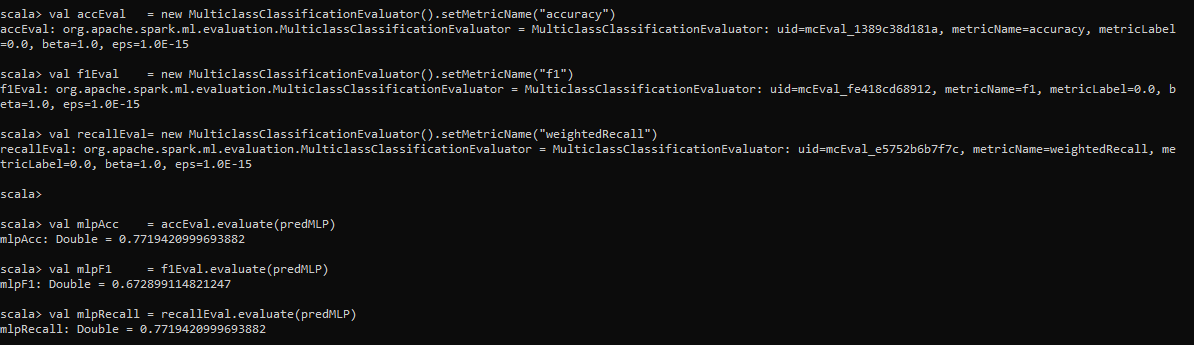

In [ ]:
import math.log

def computeLogLoss(df: org.apache.spark.sql.DataFrame): Double = {
  val eps = 1e-15
  val loglossRDD = df.select("label", "probability").rdd.map { row =>
    val label = row.getDouble(0)
    val prob = row.getAs
    val p = math.max(prob(label.toInt), eps)
    -math.log(p)
  }
  loglossRDD.mean()
}

val mlpLoss = computeLogLoss(predMLP)


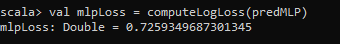

In [ ]:
val resultados = Seq(
  ("Regresión Lineal (RMSE)", rmse, mae, r2, Double.NaN),
  ("Multilayer Perceptron", mlpAcc, mlpRecall, mlpF1, mlpLoss)
).toDF("Modelo", "Accuracy/RMSE", "Recall/MAE", "F1_score/R2", "LogLoss")

resultados.show(false)


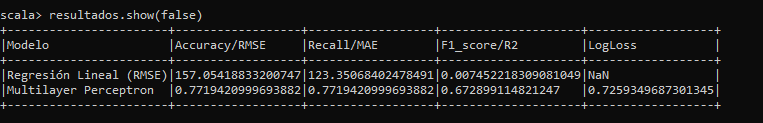

**Interpretación resultados**

Análisis de Regresión Lineal
Objetivo: predecir la NOTA del postulante.
Resultado:

RMSE = 157.05

MAE = 123.35

R² = 0.0074

Interpretación:

RMSE y MAE muy grandes

Las notas tienen valores alrededor de 400–900.

Un error de 157 puntos significa que el modelo no está capturando bien el patrón.

R² = 0
Indica que el modelo no explica la variabilidad de la nota.
En otras palabras:

Los datos NO son lineales respecto a edad, sexo, id_area o departamento.

Depende más de factores internos del examen, no de características personales.


Análisis del Multilayer Perceptron (Clasificador)
Objetivo: predecir la clase SITUACION

(“ALCANZÓ VACANTE”, “NO ALCANZÓ”, “EXAMEN ANULADO”, “NO SE PRESENTÓ”)

Resultados:

Accuracy = 0.772

Recall = 0.772

F1 = 0.673

LogLoss = 0.726

Interpretación:

Accuracy ~77%
Muy aceptable para un modelo base.
MLP aprendió relaciones no lineales entre nota + edad + carrera + sexo + región.

F1 = 0.67
F1 indica equilibrio entre:

precisión (predicciones correctas)

recall (detección correcta de clases)

Es un buen valor para un dataset desigual como el de admisión (donde muchos alcanzan o no alcanzan).

Recall = Accuracy
Esto ocurre cuando el modelo balancea bien todas las clases.

LogLoss = 0.72
Un valor relativamente bajo.
Mide cuán buena es la probabilidad predicha, no solo la clase.

Conclusión:
El MLP funciona bien y aprende relaciones más complejas que los árboles.